In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [3]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [4]:
#import shelve

In [5]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [6]:
#np.save("img_shift.npy", img_shift2)

In [7]:
img_shift2 = np.load("img_shift.npy")

In [8]:
from scipy import ndimage

In [9]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
#Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [10]:
from random import choices
from scipy.linalg import null_space

In [45]:
def is_smooth(img_shift, x, y, radius=2):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True

In [46]:
map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y in range(30, img_r.shape[0] - 30):
    for x in range(30, img_r.shape[1] - 30):
        x_norm = [x, y, 1]
        dot_shift = img_shift2[y, x]
        
        x2 = int(x + dot_shift[0])
        y2 = int(y + dot_shift[1] - kv_half)
        x_strich = [x2, y2, 1]
        
        if is_smooth(img_shift2, x, y):
            pairs.append([x_norm, x_strich])
            map2draw[y,x] = 255
        else:
            rejected_pairs.append([x_norm, x_strich])

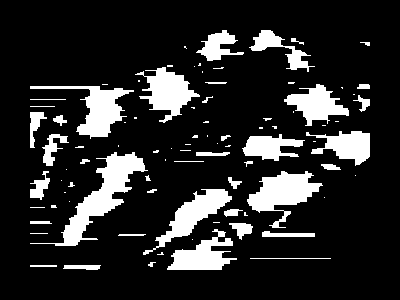

In [47]:
Image.fromarray(map2draw)

In [48]:
len(pairs)

19072

In [49]:
len(rejected_pairs)

62528

In [64]:
Boundary = 0.001
bestF = None
bestScore = 0

a_2 = np.array([i[0] for i in pairs])
b_2 = np.array([i[1] for i in pairs])

for iteration in range(20000):
    #print(iteration, end=" ")
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for a,b in seven_pairs:
        x1, y1, z1 = a
        x2, y2, z2 = b
        X_big.append([x2*x1, x2*y1, x2*z1, y2*x1, y2*y1, y2*z1, z2*x1, z2*y1, z2*z1])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f2),
    ])
    coefs = np.roots(p)
    for i in coefs[:1]:
        if np.iscomplex(i):
            continue
        F = f1+i*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', b_2, F, a_2)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.0011010906040268456
[[0.37540089]
 [0.92685028]
 [0.00476667]]
X: 78.75545146222929
Y: 194.44416309263727
hit 0.010067114093959731
[[0.55750225]
 [0.83016782]
 [0.00355387]]
X: 156.8718261717553
Y: 233.59536464605563
hit 0.026426174496644295
[[-0.81482589]
 [-0.57969848]
 [-0.00290498]]
X: 280.4930636578826
Y: 199.55355673697184
hit 0.0501258389261745
[[-0.4539041 ]
 [-0.89104362]
 [-0.00351247]]
X: 129.22646180029568
Y: 253.680050458608
hit 0.06727139261744966
[[ 0.99562336]
 [-0.09326845]
 [ 0.00592662]]
X: 167.99167127870578
Y: -15.737199635636971
hit 0.3105075503355705
[[-1.15203218e-04]
 [-9.99999993e-01]
 [-6.91509157e-07]]
X: 166.5968077334835
Y: 1446112.4378347176


## Фундаментальна матриця

In [51]:
np.round(bestF, 2)

array([[ -0.  ,  -0.  , -15.88],
       [  0.  ,   0.  ,  -0.  ],
       [ 15.88,   0.  , 127.06]])

In [52]:
bestF

array([[-2.36654032e-07, -1.66850326e-05, -1.58823691e+01],
       [ 1.67666321e-05,  8.90737679e-08, -1.78094423e-03],
       [ 1.58824101e+01,  1.88389344e-03,  1.27058811e+02]])

In [53]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [54]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [55]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [56]:
print(round(100*bestScore/len(pairs), 2),"%")

29.19 %


## Епіполярна точка у 3-х координатах

In [57]:
epipole = null_space(bestF, 1e-3)
epipole = epipole/epipole[-1]
epipole

array([[ 1.04909172e+02],
       [-9.51895301e+05],
       [ 1.00000000e+00]])

In [58]:
np.linalg.det(bestF)

2.2474704462849097e-05

In [59]:
epipole_strich = [epipole[0,0], epipole[1,0]]

## Епіполярна точка

In [60]:
print("X:", epipole_strich[0])
print("Y:", epipole_strich[1])

X: 104.9091724199619
Y: -951895.3011069959


## Ліве зображення

In [61]:
from PIL import ImageDraw

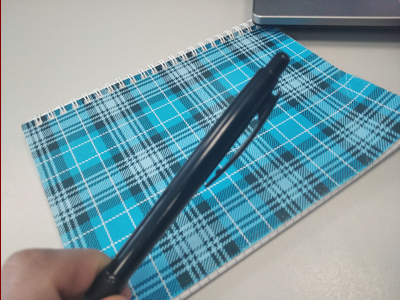

In [62]:
image2show = Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)
for i in range(11):
    draw.line((0, i*30, epipole_strich[0], epipole_strich[1]), fill=128)
image2show

## Праве зображення

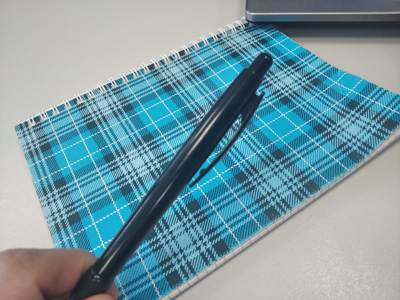

In [63]:
Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")